In [ ]:
# https://github.com/polygon-io/client-python
# !pip install polygon-api-client polygon

### 필요 라이브러리 호출

In [2]:
# import libraries
import keyring
import pandas as pd
import yfinance as yf
from polygon import RESTClient
from langchain.agents.agent_types import AgentType
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
import os
from langchain_core.tools import tool
from pathlib import Path
from langchain_openai import ChatOpenAI
os.getcwd()

'd:\\projects\\github\\learning\\llm\\agent\\projects\\analysis_report'

### Polygon API 사이트

- Polygon 홈페이지 : https://polygon.io/

In [3]:
# Polygon API site
BASE_DIR = Path(os.getcwd())        # current directory path
DATA_DIR = BASE_DIR / "data"        # directory for saving data
CHART_DIR = BASE_DIR / "charts"     # directory for saving charts

polygon_client = RESTClient(api_key=keyring.get_password('polygon', 'key_for_windows'))

### yfinance, Polygon API로 자사, 경쟁사 주식정보 가져오기

In [4]:
# get stock prices of related companies and competitors using yfinance and polygon api
related_companies = polygon_client.get_related_companies("NVDA")
competitors = [i.ticker for i in related_companies]
competitors

['AMD',
 'META',
 'GOOGL',
 'TSLA',
 'GOOG',
 'MSFT',
 'AMZN',
 'AAPL',
 'INTC',
 'AVGO']

In [5]:
@tool
def fetch_stock_data(ticker: str, start_date: str, end_date: str):
    """Fetch stock data and compare with NASDAQ and competitors."""
    stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
    nasdaq = yf.download('^IXIC', start=start_date, end=end_date, progress=False)
    
    df = pd.DataFrame(index=stock.index)
    df[f'{ticker}'] = stock['Adj Close']
    df['Nasdaq'] = nasdaq['Adj Close']
    
    related_companies = polygon_client.get_related_companies(ticker)
    competitors = [i.ticker for i in related_companies]
    
    for comp in competitors:
        try:
            comp_ticker = comp.replace('.', '-') if '.' in comp else comp
            comp_data = yf.download(comp_ticker, start=start_date, end=end_date, progress=False)
            if not comp_data.empty:
                df[comp] = comp_data['Adj Close']
        except Exception as e:
            print(e)
            continue
    csv_path = DATA_DIR / 'stock_data.csv'
    df.to_csv(csv_path)
    return f"Stock file saved to {csv_path}"

In [6]:
fetch_stock_data.run({
    "ticker": "NVDA",
    "start_date": "2023-01-01",
    "end_date": "2024-01-01"
})

'Stock file saved to d:\\projects\\github\\learning\\llm\\agent\\projects\\analysis_report\\data\\stock_data.csv'

### Polygon API로 재무 정보 가져오기

In [36]:
import time
# get financial statements using polygon api

client = polygon_client
# collect data of recent n years
financials = []
for f in polygon_client.vx.list_stock_financials('NVDA'):
    try:
        if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - 2}-01-01":
            financials.append(f)
            time.sleep(10)
    except Exception as e:
        print(e)
        break

In [37]:
financials

[StockFinancial(cik='0001045810', company_name='NVIDIA CORP', end_date='2024-07-28', filing_date='2024-08-28', financials=Financials(balance_sheet={'other_current_liabilities': DataPoint(formula=None, label='Other Current Liabilities', order=740, unit='USD', value=9348000000.0, xpath=None), 'equity': DataPoint(formula=None, label='Equity', order=1400, unit='USD', value=58157000000.0, xpath=None), 'other_noncurrent_liabilities': DataPoint(formula=None, label='Other Non-current Liabilities', order=820, unit='USD', value=4640000000.0, xpath=None), 'assets': DataPoint(formula=None, label='Assets', order=100, unit='USD', value=85227000000.0, xpath=None), 'noncurrent_assets': DataPoint(formula=None, label='Noncurrent Assets', order=300, unit='USD', value=25594000000.0, xpath=None), 'inventory': DataPoint(formula=None, label='Inventory', order=230, unit='USD', value=6675000000.0, xpath=None), 'long_term_debt': DataPoint(formula=None, label='Long-term Debt', order=810, unit='USD', value=846100

In [43]:
@tool
def get_financial_data(ticker: str, num_years: int):
    """ 
    get financial data of a given ticker, convert into dataframe and return the file path
    
    Parameters:
    ticker (str): stock code
    num_years (int): target year
    
    Returns:
    str: file path
    """
    
    # polygon REST API Client 설정
    client = polygon_client
    
    # getting quarterly financial statements data with recent n years
    financials = []
    try:
        for f in client.vx.list_stock_financials(ticker):
            if "Q" in f.fiscal_period and f.end_date >= f"{pd.Timestamp.now().year - num_years}-01-01":
                financials.append(f)
                time.sleep(10)
    except Exception as e:
        print(e)
            
    # initialize data list for creating a dataframe
    data = {
        # basic info
        "Fiscal Year": [],
        "Fiscal Period": [],
        "End Date": [],
        
        # profit/loss
        "Revenues": [],
        "Cost of Revenue": [],
        "Gross Profit": [],
        "Operating Income": [],
        "Operating Expenses": [],
        "Basic EPS": []
    }
    
    # construct dataframe with financial statements
    for i, f in enumerate(financials):
        # basic info
        data['Fiscal Year'].append(f.fiscal_year)
        data['Fiscal Period'].append(f.fiscal_period)
        data['End Date'].append(f.end_date)
        
        # financial data
        bs = f.financials.balance_sheet
        is_ = f.financials.income_statement
        cf = f.financials.cash_flow_statement
        ci = f.financials.comprehensive_income
        
        # profit/loss data
        revenue = getattr(is_.revenues, 'value', None) if hasattr(is_, 'revenues') else None
        data['Revenues'].append(revenue)
        data['Cost of Revenue'].append(getattr(is_.cost_of_revenue, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data['Gross Profit'].append(getattr(is_.gross_profit, 'value', None) if hasattr(is_, 'gross_profit') else None)
        data['Operating Expenses'].append(getattr(is_.operating_expenses, 'value', None) if hasattr(is_, 'operating_expenses') else None)
        data['Operating Income'].append(getattr(is_.operating_income, 'value', None) if hasattr(is_, 'operating_income') else None)
        data['Basic EPS'].append(getattr(is_.basic_earnings_per_share, 'value', None) if hasattr(is_, 'basic_earnings_per_share') else None)
        
    # create dataframe and sort order
    df = pd.DataFrame(data)
    df.sort_values(by='End Date', ascending=False, inplace=True)
    
    # change the column names into Korean
    korean_columns = {
        "Fiscal Year": "회계연도",
        "Fiscal Period": "회계기간",
        "End Date": "기준일",
        "Revenues": "매출액",
        "Cost of Revenue": "매출원가",
        "Gross Profit": "매출총이익",
        "Operating Income": "영업이익",
        "Operating Expenses": "영업비용",
        "Basic EPS": "기본주당순이익익"
    }
    
    df.rename(columns=korean_columns, inplace=True)
    
    # save into csv file
    csv_path = DATA_DIR / 'financial_data.csv'
    df.to_csv(csv_path, encoding='utf-8-sig')   # utf-8-sig로 저장하여 한글 깨짐 방지
    return f"재무제표 데이터가 {csv_path}에 저장되었습니다."

In [44]:
get_financial_data.run({"ticker": "NVDA", "num_years": 2})

'재무제표 데이터가 d:\\projects\\github\\learning\\llm\\agent\\projects\\analysis_report\\data\\financial_data.csv에 저장되었습니다.'

### `create_pandas_dataframe_agent`로 데이터 분석 도구 만들기

In [47]:
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# analytis tool using create_pandas_dataframe_agent
@tool
def analyze_data(query: str):
    """analyze the saved stock prices and financial data and answer the question using pandas_agent"""
    stock_csv_path = DATA_DIR / 'stock_data.csv'
    finana_csv_path = DATA_DIR / 'financial_data.csv'
    stock_df = pd.read_csv(stock_csv_path)
    finance_df = pd.read_csv(finana_csv_path)
    custom_prefix = f"""
    You are very smart analyst who can stock_data and finance_data.
    Please analyze the data in various perspective to find valuable insight.
    You should always make the greatest output with accurate metrics and tables.
    stock_data path: {stock_csv_path}
    finance_data path: {finana_csv_path}
    """
    pandas_agent = create_pandas_dataframe_agent(
        ChatOpenAI(model='gpt-4o'),
        [stock_df, finance_df],
        verbose=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        allow_dangerous_code=True,
        prefix=custom_prefix
    )
    
    result = pandas_agent.run(query)
    return result

C:\Users\ahn28\AppData\Local\Temp\ipykernel_14816\2267312599.py:28: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = pandas_agent.run(query)




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load stock data\ndf_stock = pd.read_csv('d:/projects/github/learning/llm/agent/projects/analysis_report/data/stock_data.csv')\n\n# Convert 'Date' to datetime format\ndf_stock['Date'] = pd.to_datetime(df_stock['Date'])\n\n# Plot NVDA price trend\nplt.figure(figsize=(10, 5))\nplt.plot(df_stock['Date'], df_stock['NVDA'], label='NVDA', color='blue')\nplt.title('NVDA Stock Price Trend')\nplt.xlabel('Date')\nplt.ylabel('Price')\nplt.grid(True)\nplt.legend()\nplt.show()"}`




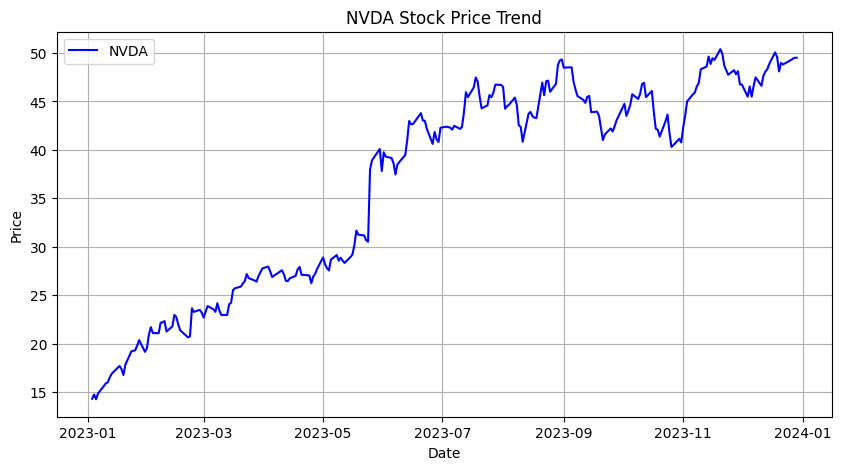

위의 그래프는 2023년 1월부터 NVDA 주식 가격의 추이를 보여줍니다. 그래프를 통해 시간에 따른 NVDA의 주가 변동을 시각적으로 확인할 수 있습니다. 주가가 상승하거나 하락하는 패턴을 관찰하여 시장의 변동성을 이해하는 데 도움이 됩니다. 

이 추세를 통해 NVDA 주식의 투자 기회를 파악하거나, 시장의 다른 주식과 비교하여 NVDA의 상대적인 성과를 분석할 수 있습니다. 추가적으로, 특정 시점에 주가가 급격히 변동한 이유를 탐색하거나, 외부 요인과의 상관관계를 조사할 수도 있습니다. 

더 구체적인 분석을 원하시면 말씀해 주세요!

> Finished chain.


'위의 그래프는 2023년 1월부터 NVDA 주식 가격의 추이를 보여줍니다. 그래프를 통해 시간에 따른 NVDA의 주가 변동을 시각적으로 확인할 수 있습니다. 주가가 상승하거나 하락하는 패턴을 관찰하여 시장의 변동성을 이해하는 데 도움이 됩니다. \n\n이 추세를 통해 NVDA 주식의 투자 기회를 파악하거나, 시장의 다른 주식과 비교하여 NVDA의 상대적인 성과를 분석할 수 있습니다. 추가적으로, 특정 시점에 주가가 급격히 변동한 이유를 탐색하거나, 외부 요인과의 상관관계를 조사할 수도 있습니다. \n\n더 구체적인 분석을 원하시면 말씀해 주세요!'

In [48]:
analyze_data.run({"query": "NVDA 가격 추이를 분석해줘."})

### 차트 생성 도구 만들기

In [53]:
# tool for creating charts
@tool
def chart_generator(command: str):
    """this tool creates charts and saves into /charts folder using create_pandas_dataframe_agent"""
    stock_data = pd.read_csv(DATA_DIR / 'stock_data.csv')
    finance_data = pd.read_csv(DATA_DIR / 'financial_data.csv')
    custom_prefix = """ 
    Please make the chart and save in './charts/' folder.
    stock_path is './data//stock_data.csv'.
    finance_data is './data/financial_data.csv'
    """
    
    agent = create_pandas_dataframe_agent(
        ChatOpenAI(model_name='gpt-4o'),
        [stock_data, finance_data],
        verbose=True,
        allow_dangerous_code=True,
        agent_type=AgentType.OPENAI_FUNCTIONS,
        prefix=custom_prefix
    )
    
    result = agent.invoke(command)
    return result

In [54]:
chart_generator.run({"command": "NVDA stock price chart"})



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# Load the stock data\ndf = pd.read_csv('./data/stock_data.csv')\n\n# Convert 'Date' to datetime format\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Plot NVDA stock price\ndf.plot(x='Date', y='NVDA', title='NVDA Stock Price', ylabel='Price ($)', xlabel='Date')\n\n# Save the plot\nplt.savefig('./charts/nvda_stock_price.png')\nplt.close()"}`


The NVDA stock price chart has been created and saved as `nvda_stock_price.png` in the `./charts/` folder.

> Finished chain.


{'input': 'NVDA stock price chart',
 'output': 'The NVDA stock price chart has been created and saved as `nvda_stock_price.png` in the `./charts/` folder.'}